In [2]:
import torchaudio.transforms as T
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import math


### encoder <최종>
* 호환성을 update 할 필요가 있음.

In [19]:
class multi_label_encoder:
    """
    role : label encode
    """
    def __init__(self, fs = 16000, audio_len = 60, n_fft = 640, hop_length = 80, net_pooling = 1):
        self.fs = fs # 나중에 바꿔줘야 함, 사용 안함.
        self.audio_len = audio_len # unit : second

        self.hop_length = hop_length   #mel-spectrogram
        self.n_fft = n_fft             #mel-spectrogram
        
        self.net_pooling = net_pooling  # input frame -> output frame 에서 어떤 비율로 감소하는지. 
        # 1이면 input frame = outputframe
        # 2면   input frame = 2 * output frame

        n_samples = self.audio_len * self.fs

        self.n_frames = int(int((n_samples/ self.hop_length)) / self.net_pooling)

    def _time_to_frame(self, time):
        samples = time * self.fs
        frame = (samples) / self.hop_length
        return np.clip(frame / self.net_pooling, a_min=0, a_max=self.n_frames)


    def encoder_strong_label(self, xml_dir):
        """Encode a list of strong label"""
        xml = ET.parse(xml_dir)
        root = xml.getroot()

        item = root.find("events").findall("item")


        onset = [float(x.findtext("STARTSECOND")) for x in item] # list, str
        offset = [float(x.findtext("ENDSECOND")) for x in item]  # list, str
        label_idx = [int(x.findtext("CLASS_ID")) for x in item] 

        target = np.zeros([self.n_frames, 3], dtype = 'float32') # shape : [frame, class], class : 3



        if (len(onset) != len(offset)): 
            print("wrong")
        else:
            for i in range(len(onset)):
                start = int(self._time_to_frame(onset[i])) #버림 -> 해당 time frame에 걸쳐있으면 true??
                end = int(np.ceil(self._time_to_frame(offset[i])))   #올림 -> 해당 time frame에 걸쳐있으면 true
                target[start:end, (label_idx[i]-1)] = 1 # (class_id[i]-1) = 1 : scream, 2 : tire skidding, 3 : car crash
            


        # print(onset)
        # print(offset)

        return (target)


def matplotlib_label_show(target):
    n_frame = target.shape[0] # target.shape[0] = segment

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x = np.arange(n_frame)  #(60,)
    y1 = target[:,0]        #(60,) 
    y2 = target[:,1]        #(60,) tire skidding
    y3 = target[:,2]        #(60,) car crash

    ax1.plot(x, y1, label = 'scream')
    ax1.plot(x, y2, label = 'tire skidding', color = 'orange')
    ax1.plot(x, y3, label = 'car crash', color = 'green')


    ax1.legend(framealpha = 1, loc = 'lower right', bbox_to_anchor=(1.4,0))
    # ax1.set_title('{}'.format(xmlfile))


    plt.show()


### n_frame 검증
*  n_samples = self.audio_len * self.fs  # 60 * 16000 = 960000
* int(n_samples / hop_length) = 960000 / 80

* 1 차이가 나는데, 왜 그런지...

In [4]:
print(int(960000/80))
print(int(int((960000/ 80)) / 4))

12000
3000


In [5]:
import math
n_frames = int(math.ceil(960000/2/80)*2 / 4)
print(n_frames)

3000


### label 시각화 함수

In [6]:
def matplotlib_label_show(target):
    n_frame = target.shape[0] # target.shape[0] = segment

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x = np.arange(n_frame)  #(60,)
    y1 = target[:,0]        #(60,) 
    y2 = target[:,1]        #(60,) tire skidding
    y3 = target[:,2]        #(60,) car crash

    ax1.plot(x, y1, label = 'scream')
    ax1.plot(x, y2, label = 'tire skidding', color = 'orange')
    ax1.plot(x, y3, label = 'car crash', color = 'green')


    ax1.legend(framealpha = 1, loc = 'lower right', bbox_to_anchor=(1.4,0))
    # ax1.set_title('{}'.format(xmlfile))


    plt.show()


# 수정 전
# def matplotlib_label_show(target, xmlfile):
#     segment = target.shape[0] # target.shape[0] = segment

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111)

#     x = np.arange(segment)  #(60,)
#     y1 = target[:,0]        #(60,) 
#     y2 = target[:,1]        #(60,) tire skidding
#     y3 = target[:,2]        #(60,) car crash

#     ax1.plot(x, y1, label = 'scream')
#     ax1.plot(x, y2, label = 'tire skidding', color = 'orange')
#     ax1.plot(x, y3, label = 'car crash', color = 'green')


#     ax1.legend(framealpha = 1, loc = 'lower right', bbox_to_anchor=(1.4,0))
#     ax1.set_title('{}'.format(xmlfile))


#     plt.show()
# 

# 여기서 부터 실험
* 이 아래는 백업 안해도 됨

In [7]:
import yaml

with open('..\\config\\default.yml') as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)

In [8]:
xml_dir = '../data/mivia_raw/audio/A/00001.xml'

In [9]:
encoder = multi_label_encoder(
    fs = conf['feats']['sample_rate'], 
    audio_len = conf['feats']['audio_len'], 
    n_fft = conf['feats']['n_fft'], 
    hop_length = conf['feats']['hop_length'], 
    net_pooling = conf['feats']['net_pooling']
    )


In [10]:
target = encoder.encoder_strong_label(xml_dir)

In [11]:
print(target)
print(target.shape)
print(target.dtype)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(3750, 3)
float64


In [12]:
# print(target)
print(target[:,0])
print(target[:,1])
print(target[:,2])

target.shape[0]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


3750

### 여기서 부터 encode 결과 시각화

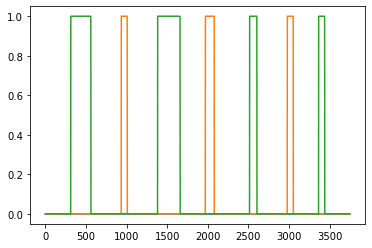

In [13]:
n_frames = 3750

fig = plt.figure()

ax1 = fig.add_subplot(111)

x = np.arange(n_frames)  #(60,)
y1 = target[:,0]        #(60,)
y2 = target[:,1]        #(60,) tire skidding
y3 = target[:,2]        #(60,) car crash

ax1.plot(x, y1)
ax1.plot(x, y2)
ax1.plot(x, y3)


plt.show()

### 다른 xml file 결과보기

In [14]:
xmlfile = '../data/mivia_raw/audio/A/00002.xml'

In [15]:
encoder = multi_label_encoder()
target = encoder.encoder_strong_label(xmlfile)

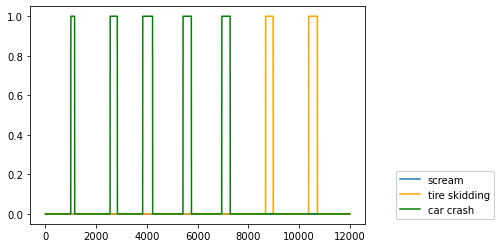

In [16]:
matplotlib_label_show(target)

In [17]:
print(target.shape)

(12000, 3)


ValueError: x and y must have same first dimension, but have shapes (60,) and (12000,)

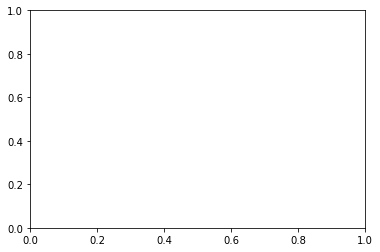

In [18]:
segment = 60

fig = plt.figure()

ax1 = fig.add_subplot(111)

x = np.arange(segment)  #(60,)
y1 = target[:,0]        #(60,)
y2 = target[:,1]        #(60,)
y3 = target[:,2]        #(60,)

ax1.plot(x, y1, label = 'scream')
ax1.plot(x, y2, label = 'tire skidding', color = 'orange')
ax1.plot(x, y3, label = 'car crash', color = 'green')

ax1.legend(framealpha = 1, loc = 'lower right', bbox_to_anchor=(1.4,0))
ax1.set_title('{}'.format(xmlfile))


plt.show()

### filter_aug_sed CRNN input test
* crnn에 input을 넣고, input의 frame과 output의 frame을 비교
* 이 실험으로 net_pooling의 역할을 알 수 있었음

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
#Some codes are adopted from https://github.com/DCASE-REPO/DESED_task
import torch
import torch.nn as nn


class GLU(nn.Module):
    def __init__(self, in_dim):
        super(GLU, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(in_dim, in_dim)

    def forward(self, x): #x size = [batch, chan, freq, frame]
        lin = self.linear(x.permute(0, 2, 3, 1)) #x size = [batch, freq, frame, chan]
        lin = lin.permute(0, 3, 1, 2) #x size = [batch, chan, freq, frame]
        sig = self.sigmoid(x)
        res = lin * sig
        return res


class ContextGating(nn.Module):
    def __init__(self, in_dim):
        super(ContextGating, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(in_dim, in_dim)

    def forward(self, x): #x size = [batch, chan, freq, frame]
        lin = self.linear(x.permute(0, 2, 3, 1)) #x size = [batch, freq, frame, chan]
        lin = lin.permute(0, 3, 1, 2) #x size = [batch, chan, freq, frame]
        sig = self.sigmoid(lin)
        res = x * sig
        return res


class CNN(nn.Module):
    def __init__(self,
                 n_input_ch,
                 activation="Relu",
                 conv_dropout=0,
                 kernel=[ 3, 3, 3, 3, 3, 3, 3 ],
                 pad=[ 1, 1, 1, 1, 1, 1, 1 ],
                 stride=[ 1, 1, 1, 1, 1, 1, 1 ],
                 n_filt=[ 32, 64, 128, 256, 256, 256, 256 ],
                 pooling=[ [ 2, 2 ], [ 2, 2 ], [ 1, 2 ], [ 1, 2 ], [ 1, 2 ], [ 1, 2 ], [ 1, 2 ] ],
                 normalization="batch"):
        super(CNN, self).__init__()
        self.n_filt = n_filt
        self.n_filt_last = n_filt[-1]
        cnn = nn.Sequential()

        def conv(i, normalization="batch", dropout=None, activ='relu'):
            in_dim = n_input_ch if i == 0 else n_filt[i - 1]
            out_dim = n_filt[i]
            cnn.add_module("conv{0}".format(i), nn.Conv2d(in_dim, out_dim, kernel[i], stride[i], pad[i]))
            if normalization == "batch":
                cnn.add_module("batchnorm{0}".format(i), nn.BatchNorm2d(out_dim, eps=0.001, momentum=0.99))
            elif normalization == "layer":
                cnn.add_module("layernorm{0}".format(i), nn.GroupNorm(1, out_dim))

            if activ.lower() == "leakyrelu":
                cnn.add_module("Relu{0}".format(i), nn.LeakyReLu(0.2))
            elif activ.lower() == "relu":
                cnn.add_module("Relu{0}".format(i), nn.ReLu())
            elif activ.lower() == "glu":
                cnn.add_module("glu{0}".format(i), GLU(out_dim))
            elif activ.lower() == "cg":
                cnn.add_module("cg{0}".format(i), ContextGating(out_dim))

            if dropout is not None:
                cnn.add_module("dropout{0}".format(i), nn.Dropout(dropout))

        for i in range(len(n_filt)):
            conv(i, normalization=normalization, dropout=conv_dropout, activ=activation)
            cnn.add_module("pooling{0}".format(i), nn.AvgPool2d(pooling[i]))
        self.cnn = cnn

    def forward(self, x):
        x = self.cnn(x)
        return x


class BiGRU(nn.Module):
    def __init__(self, n_in, n_hidden, dropout=0, num_layers=1):
        super(BiGRU, self).__init__()
        self.rnn = nn.GRU(n_in, n_hidden, bidirectional=True, dropout=dropout, batch_first=True, num_layers=num_layers)

    def forward(self, x):
        #self.rnn.flatten_parameters()
        x, _ = self.rnn(x)
        return x


class CRNN(nn.Module):
    def __init__(self,
                 n_input_ch = 1,
                 n_class=10,
                 activation="cg",
                 conv_dropout=0.5,
                 n_RNN_cell=256,
                 n_RNN_layer=2,
                 rec_dropout=0,
                 attention=True,
                 **convkwargs):
        super(CRNN, self).__init__()
        self.n_input_ch = n_input_ch
        self.attention = attention
        self.n_class = n_class

        self.cnn = CNN(n_input_ch=n_input_ch, activation=activation, conv_dropout=conv_dropout, **convkwargs)
        self.rnn = BiGRU(n_in=self.cnn.n_filt[-1], n_hidden=n_RNN_cell, dropout=rec_dropout, num_layers=n_RNN_layer)

        self.dropout = nn.Dropout(conv_dropout)
        self.sigmoid = nn.Sigmoid()

        self.dense = nn.Linear(n_RNN_cell * 2, n_class)

        if self.attention:
            self.dense_softmax = nn.Linear(n_RNN_cell * 2, n_class)
            self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): #input size : [bs, freqs, frames]
        #cnn
        if self.n_input_ch > 1:
            x = x.transpose(2, 3)
        else:
            x = x.transpose(1, 2).unsqueeze(1) #x size : [bs, chan, frames, freqs]

        print(x.shape)
        x = self.cnn(x)
        bs, ch, frame, freq = x.size()
        if freq != 1:
            print("warning! frequency axis is large: " + str(freq))
            x = x.permute(0, 2, 1, 3)
            x = x.contiguous.view(bs, frame, ch*freq)
        else:
            x = x.squeeze(-1)
            x = x.permute(0, 2, 1) # x size : [bs, frames, chan]

        #rnn
        x = self.rnn(x) #x size : [bs, frames, 2 * chan]
        x = self.dropout(x)

        #classifier
        strong = self.dense(x) #strong size : [bs, frames, n_class]
        strong = self.sigmoid(strong)
        if self.attention:
            sof = self.dense_softmax(x) #sof size : [bs, frames, n_class]
            sof = self.softmax(sof) #sof size : [bs, frames, n_class]
            sof = torch.clamp(sof, min=1e-7, max=1)
            weak = (strong * sof).sum(1) / sof.sum(1) # [bs, n_class]
        else:
            weak = strong.mean(1)
        return strong.transpose(1, 2), weak




In [ ]:
model = CRNN(n_input_ch = 1)

In [ ]:
a = torch.randn(64, 128, 160)
# a = 

In [ ]:
strong, weak = model(a)

torch.Size([64, 1, 160, 128])


In [ ]:
strong.shape

torch.Size([64, 10, 40])